In [1]:
from __future__ import print_function
from fenics import *
import numpy as np
import scipy
import random
import matplotlib.pyplot as plt
import copy
%matplotlib inline

In [15]:
"""
2D random heat equation with forcing term f = 0
 
 
  du/dt = - div(a(ξ)∇u)   in the unit square
  u = 0                   on the boundary
  u = u_0                 at t = 0
 
  D = [0,1]^2  is physical space
  Τ = [-1,1]^M  is sample space

a(x,ξ) = 0.3 + sum_{m=1}^M (cos(2πmx1)+cos(2πmx2)/m^2π^2 * ξm)
u_0 = 10 sin(πx1) sin(πx2) + 4/3 sin(6πx1) sin(6πx2) + 2 sin(2πx1) sin(2πx2)ξ1 + 2 sin(4πx1) sin(4πx2)ξ2 + 2 sin(6πx1) sin(6πx2)(ξ1^2 − E[ξ1^2])

"""

class DLR:
    def __init__(self,dt,n,M,R = 3,sample_size = 50):
        self.dt = dt # time step
        self.nx = n # number of mesh
        self.ny = n
        self.h = 1 / n # element size
        self.M = M # The number of random variables( The number of truncation of a(ξ))
        self.R = R # rank of DLR
        self.sample_size = sample_size # stochastic discretization

        self.mesh = UnitSquareMesh(self.nx, self.ny)
        self.V = FunctionSpace(self.mesh, 'P', 1)
        # self.V_R = MixedFunctionSpace([self.V] * self.R)

        ## Define boundary condition
        self.bc = DirichletBC(self.V, Constant(0), 'on_boundary')

        
        ## Initialize functions 
        #set random values
        self.sampled = self.sampling() #(M,self.sample_size) ,unifrom random values in T
        ksi_1 = self.sampled[0]
        ksi_2 = self.sampled[1]

        # E[u]
        mean = Expression('10 * sin(pi * x[0]) * sin(pi * x[1]) + 4/3 * sin(6 * pi * x[0]) * sin(6 * pi * x[1])',degree=3) 
        self.mean = interpolate(mean,self.V)  #(V_h)
        self.mean_n = interpolate(mean,self.V) 
        
        
        # deterministic basis functions
        self.U = []#  (R,V_h) # R=3
        self.U_n = []
        U_1 = Expression('2 * sin(2 * pi * x[0]) * sin(2 * pi * x[1])',degree=3)
        self.U.append(interpolate(U_1,self.V))
        self.U_n.append(interpolate(U_1,self.V))
        U_2 = Expression('2 * sin(4 * pi * x[0]) * sin(4 * pi * x[1])',degree=3)
        self.U.append(interpolate(U_2,self.V))
        self.U_n.append(interpolate(U_2,self.V))
        U_3 = Expression('2 * sin(6 * pi * x[0]) * sin(6 * pi * x[1])',degree=3)
        self.U.append(interpolate(U_3,self.V))
        self.U_n.append(interpolate(U_3,self.V))
        
        # stochatic basis functions                
        self.Y = [] #(R,sample_size) # R=3
        Y_1 = ksi_1
        self.Y.append(Y_1)
        Y_2 = ksi_2
        self.Y.append(Y_2)
        Y_3 = ksi_1 ** 2 - 2/3
        self.Y.append(Y_3)
        
        
        self.matrix = np.zeros((R,R))

        ## set coefficient
        self.a_0 = Constant(0.3) #(L^♾️)
        self.a_sto = [] #(sample_size,L^♾️)
        self.a = [] #(sample_size,L^♾️)
        for i in range(self.sample_size):
            str_expr = ""
            for j in range(1, self.M + 1):
                str_expr += f"( cos(2 * pi * {j} * x[0] ) + cos(2 * pi * {j} * x[1] ) ) / ({j} * {j} * pi * pi) * sampled[{j-1}] + "
            str_expr = str_expr[:-3]
            self.a_sto.append(Expression(str_expr, degree=3, sampled=Constant(self.sampled[:,i])))
            str_expr += " + a_0"
            self.a.append(Expression(str_expr, degree=3, sampled=Constant(self.sampled[:,i]),a_0 = Constant(0.3)))
        # for i in range(self.sample_size):
        #     self.a[i] = interpolate(self.a[i],self.V)

                   
        ##for plot
        self.timelist = []
        self.energylist = []
        self.L2list= []

    
    def sampling(self):
        return np.random.uniform(low=-1.0, high=1.0, size=(self.M,self.sample_size))

    # calculate quadratures, M_i,j = <U_i,U_j>
    def matrix_calculate(self):
        for i in range(self.R):
            for j in range(i,self.R):
                value = assemble(inner(self.U[i], self.U[j]) * dx)
                self.matrix[i][j] = value
                self.matrix[j][i] = value

    ## subfunctions for calculating dinamics

    def E_a_grad_u(self,a):
        ans = a[0]* grad(self.mean_n + self.U_n[0] * self.Y[0][0] + self.U_n[1] * self.Y[1][0] + self.U_n[2] * self.Y[2][0])
        for i in range(1,self.sample_size):
            ans += (a[i]* grad(self.mean_n + self.U_n[0] * self.Y[0][i] + self.U_n[1] * self.Y[1][i] + self.U_n[2] * self.Y[2][i]))
        ans /= self.sample_size
        return ans

    def E_a_grad_u_Y(self,a,Y):
        ans = (a[0]* grad(self.mean_n + self.U_n[0] * self.Y[0][0] + self.U_n[1] * self.Y[1][0] + self.U_n[2] * self.Y[2][0])) * Y[0]
        for i in range(1,self.sample_size):
            ans += (a[i]* grad(self.mean_n + self.U_n[0] * self.Y[0][i] + self.U_n[1] * self.Y[1][i] + self.U_n[2] * self.Y[2][i])) * Y[i]
        ans /= self.sample_size
        return ans

    
    # def a_grad_u_grad_U(self,a):
    #     ans = np.zeros((self.R,self.sample_size)) 
    #     u = []
    #     for i in range(self.sample_size):
    #         u.append(self.mean + self.U[0] * Constant(self.Y[0][i]) + self.U[1] * Constant(self.Y[1][i]) + self.U[2] * Constant(self.Y[2][i]))
    #     for i in range(self.R):
    #         for j in range(self.sample_size):
    #             ans[i][j] = assemble(self.a[j] * dot(grad(u[j]),grad(self.U[i])) * dx)
    #     return ans

    def a_grad_u_grad_U(self,a):
        ans = np.zeros((self.R,self.sample_size)) 
        u = []
        for i in range(self.sample_size):
            u.append(self.mean + self.U[0] * Constant(self.Y[0][i]) + self.U[1] * Constant(self.Y[1][i]) + self.U[2] * Constant(self.Y[2][i]))
        for i in range(self.R):
            for j in range(self.sample_size):
                ans[i][j] = assemble(a[j] * dot(grad(u[j]),grad(self.U[i])) * dx)
        row_means = np.mean(ans, axis=1)
        ans -= row_means[:, np.newaxis]

        return ans

    
    def dt_a0_grad_U_grad_U(self):
        ans = np.zeros((self.R,self.R)) 
        for i in range(self.R):
            for j in range(i,self.R):
                value = self.dt *  assemble(self.a_0 * dot(grad(self.U[i]),grad(self.U[j])) * dx)
                ans[i][j] = value
                ans[j][i] = value
        return ans

    # def pre_assemble(self):
    #     self.u_1 = Function(self.V)
    #     self.u_2 = Function(self.V)
    #     self.u_3 = Function(self.V)
    #     self.agradugradv = self.u_3 * dot(grad(self.u_1),grad(self.u_2)) * dx
    #     assemble(self.a)

    # def a_grad_u_grad_U(self,a):
    #     ans = np.zeros((self.R,self.sample_size)) 
    #     u = []
    #     for i in range(self.sample_size):
    #         u.append(self.mean + self.U[0] * Constant(self.Y[0][i]) + self.U[1] * Constant(self.Y[1][i]) + self.U[2] * Constant(self.Y[2][i]))
    #     for i in range(self.R):
    #         for j in range(self.sample_size):
    #             ans[i][j] = assemble(self.agradugradv(coefficients={self.u_3=a[j],self.u_1 = u[j],self.u_2 = self.U[i]}))
    #                 # self.a[j] * dot(grad(u[j]),grad(self.U[i])) * dx)
    #     return ans
                             
                          

    def orthogonal_projection(self,v):
        return v - np.inner(v,self.Y[0]) * self.Y[0] - np.inner(v,self.Y[1]) * self.Y[1] - np.inner(v,self.Y[2]) * self.Y[2]

    def reorthogonalize(self):
        Q, _ = np.linalg.qr(np.transpose(self.Y))
        self.Y = np.transpose(Q)
        [self.U[0].vector()[:],self.U[1].vector()[:],self.U[2].vector()[:]] = np.matmul(_,[self.U[0].vector()[:],self.U[1].vector()[:],self.U[2].vector()[:]])


    #explicit scheme
    def explicit_simulate(self,end = 2.5):
        t = 0
        count = 0 # calculate energynorm each step is cotly so only every some steps
        self.timelist.append(t)
        energy = self.energynorm()
        self.energylist.append(energy)
        l2 = norm(self.mean,'l2')
        self.L2list.append(l2)
        print("energy norm: ", energy )
        print("L2 norm: ", l2 )

        # Define variational problem
        
        self.mean = TrialFunction(self.V)
        self.U[0] = TrialFunction(self.V)
        self.U[1] = TrialFunction(self.V)
        self.U[2] = TrialFunction(self.V)
        v = TestFunction(self.V)

        a_mean = self.mean * v * dx  
        L_mean = self.mean_n * v * dx - self.dt * dot(self.E_a_grad_u(self.a), grad(v)) * dx
        a_1 = self.U[0] * v * dx
        L_1 = self.U_n[0] * v * dx - self.dt * dot(self.E_a_grad_u_Y(self.a,self.Y[0]), grad(v)) * dx
        a_2 = self.U[1] * v * dx
        L_2 = self.U_n[1] * v * dx - self.dt * dot(self.E_a_grad_u_Y(self.a,self.Y[1]), grad(v)) * dx
        a_3 = self.U[2] * v * dx
        L_3 = self.U_n[2] * v * dx - self.dt * dot(self.E_a_grad_u_Y(self.a,self.Y[2]), grad(v)) * dx
         
        self.mean = Function(self.V)
        self.U[0] = Function(self.V)
        self.U[1] = Function(self.V)
        self.U[2] = Function(self.V)
        
        while t < end:           
            # Compute solution
            solve(a_mean == L_mean, self.mean, self.bc) 
            solve(a_1 == L_1, self.U[0], self.bc)
            solve(a_2 == L_2, self.U[1], self.bc)
            solve(a_3 == L_3, self.U[2], self.bc)
         
            self.matrix_calculate()

            det = np.linalg.det(self.matrix)
            if np.isclose(det, 0):
                break
            else:
                A = np.array([self.orthogonal_projection(self.a_grad_u_grad_U(self.a)[0]),self.orthogonal_projection(self.a_grad_u_grad_U(self.a)[1]),self.orthogonal_projection(self.a_grad_u_grad_U(self.a)[2])])
                self.Y += -self.dt * np.matmul(scipy.linalg.inv(self.matrix),A)
                
            
            # reorthogonalize
            self.reorthogonalize()

            t  += self.dt
            count += 1
            
            self.mean_n.assign(self.mean) 
            self.U_n[0].assign(self.U[0])
            self.U_n[1].assign(self.U[1])
            self.U_n[2].assign(self.U[2])
            
            if count % 1 == 0:
                self.timelist.append(t)
                energy = self.energynorm()
                self.energylist.append(energy)
                l2 = norm(self.mean,'l2')
                self.L2list.append(l2)
                print("energy norm: ", energy )
                print("L2 norm: ", l2 )
                if energy > 10 ** 7:
                    break 
                    
        self.plot_field()
        self.plot_norm()

        

    #semi implicit scheme
    def semi_implicit_simulate(self,end = 2.5):
        t = 0
        count = 0 # calculate energynorm each step is cotly so only every some steps
        self.timelist.append(t)
        energy = self.energynorm()
        self.energylist.append(energy)
        l2 = norm(self.mean,'l2')
        self.L2list.append(l2)
        print("energy norm: ", energy )
        print("L2 norm: ", l2 )

        # Define variational problem
        
        self.mean = TrialFunction(self.V)
        self.U[0] = TrialFunction(self.V)
        self.U[1] = TrialFunction(self.V)
        self.U[2] = TrialFunction(self.V)
        v = TestFunction(self.V)

        a_mean = self.mean * v * dx  + self.dt * self.a_0 * dot(grad(self.mean),grad(v)) * dx
        L_mean = self.mean_n * v * dx - self.dt * dot(self.E_a_grad_u(self.a_sto),grad(v)) * dx
        a_1 = self.U[0] * v * dx + self.dt * self.a_0 * dot(grad(self.U[0]),grad(v)) * dx
        L_1 = self.U_n[0] * v * dx - self.dt * dot(self.E_a_grad_u_Y(self.a_sto,self.Y[0]), grad(v)) * dx
        a_2 = self.U[1] * v * dx + self.dt * self.a_0 * dot(grad(self.U[1]),grad(v)) * dx
        L_2 = self.U_n[1] * v * dx - self.dt * dot(self.E_a_grad_u_Y(self.a_sto,self.Y[1]), grad(v)) * dx
        a_3 = self.U[2] * v * dx + + self.dt * self.a_0 * dot(grad(self.U[2]),grad(v)) * dx
        L_3 = self.U_n[2] * v * dx - self.dt * dot(self.E_a_grad_u_Y(self.a_sto,self.Y[2]), grad(v)) * dx
         
        self.mean = Function(self.V)
        self.U[0] = Function(self.V)
        self.U[1] = Function(self.V)
        self.U[2] = Function(self.V)

        while t < end:           
            # Compute solution
            solve(a_mean == L_mean, self.mean, self.bc) 
            solve(a_1 == L_1, self.U[0], self.bc)
            solve(a_2 == L_2, self.U[1], self.bc)
            solve(a_3 == L_3, self.U[2], self.bc)
         
            self.matrix_calculate()
            
            
            A = np.array([self.orthogonal_projection(self.a_grad_u_grad_U(self.a_sto)[0]),self.orthogonal_projection(self.a_grad_u_grad_U(self.a_sto)[1]),self.orthogonal_projection(self.a_grad_u_grad_U(self.a_sto)[2])])
            self.Y += -self.dt * np.matmul(scipy.linalg.inv(self.matrix + self.dt_a0_grad_U_grad_U()),A)
            
            # reorthogonalize
            self.reorthogonalize()

            t  += self.dt
            count += 1
            
            self.mean_n.assign(self.mean) 
            self.U_n[0].assign(self.U[0])
            self.U_n[1].assign(self.U[1])
            self.U_n[2].assign(self.U[2])
            
            if count % 1 == 0:
                self.timelist.append(t)
                energy = self.energynorm()
                self.energylist.append(energy)
                l2 = norm(self.mean,'l2')
                self.L2list.append(l2)
                print("energy norm: ", energy )
                print("L2 norm: ", l2 )
                if energy > 10 ** 7:
                    break 
                    
        self.plot_field()
        self.plot_norm()

        
        

   #energy norm

    def energynorm(self):
        u = self.mean + self.U[0] * Constant(self.Y[0][0]) + self.U[1] * Constant(self.Y[1][0]) + self.U[2] * Constant(self.Y[2][0])
        form = self.a[0] * inner(grad(u), grad(u)) * dx
        for i in range(1,self.sample_size):
            u = self.mean + self.U[0] * Constant(self.Y[0][i]) + self.U[1] * Constant(self.Y[1][i]) + self.U[2] * Constant(self.Y[2][i])
            form += self.a[i] * inner(grad(u), grad(u)) * dx
        energy = assemble(form) / self.sample_size
        return energy


    
    # monitor energy norm
    def plot_norm(self):
            plt.plot(self.timelist, self.energylist)
            plt.plot(self.timelist, self.L2list)
            plt.yscale('log')
            plt.xlabel("time")
            plt.ylabel("norm")
            plt.legend(['energy norm','L2 norm'])
            plt.show()
        
    #visualize mean function of the random field
    def plot_field(self):
        # u = self.mean + self.U[0] * np.mean(self.Y[0]) + self.U[1] * np.mean(self.Y[1]) + self.U[2] * np.mean(self.Y[2])
        plot(self.mean)
        plt.show()
        


    

   
    


192.78741442265877
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
1.3318932788950004
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
0.7341924145252304
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
0.00470062765831709
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
0.0022545882769792356
Solving linear variational problem.
Solving linear variationa

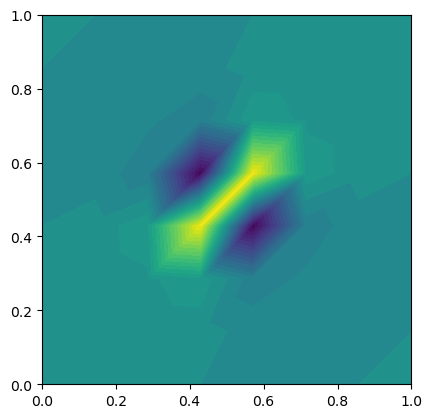

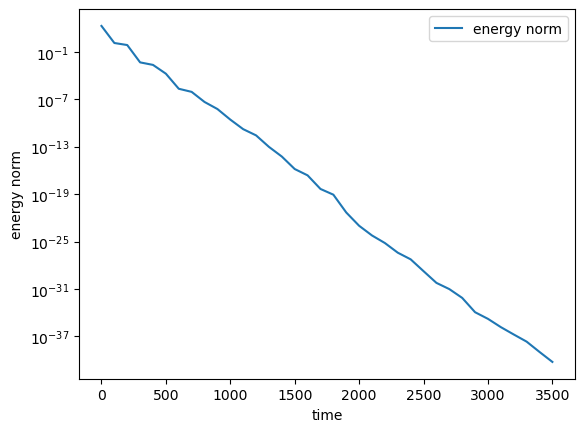

In [34]:
random_heat = DLR(dt = 100,n = 7,M = 10)
random_heat.semi_implicit_simulate(end = 3500)

190.99200908583384
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
177.74737171610803
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
163.00338014081734
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
153.35984012141864
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
146.2207050311517
Solving linear variational problem.
Solving linear variational pro

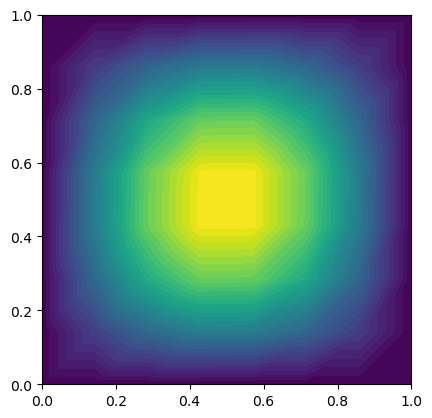

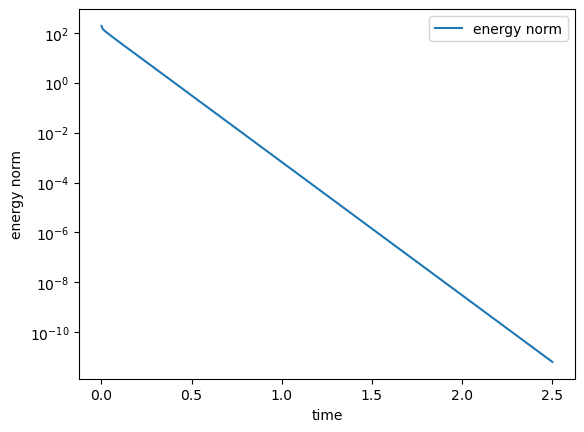

In [35]:
random_heat = DLR(dt = 0.0017,n = 7,M = 10)
random_heat.semi_implicit_simulate()

energy norm:  191.98003268994415
L2 norm:  4.845082949257364
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
energy norm:  353.6661401780506
L2 norm:  4.827038826948759
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  371.0846752785434
L2 norm:  4.80274069723338
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  417.30590852437854
L2 norm:  4.790176084262041
Solving linear variational problem.
Solving linear variational 

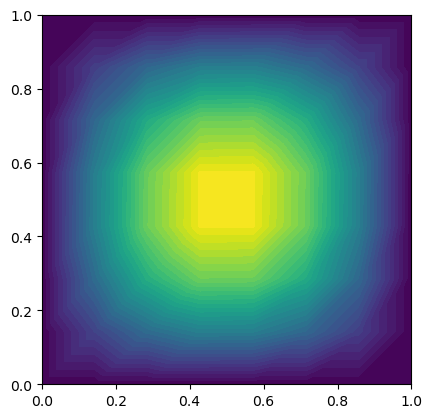

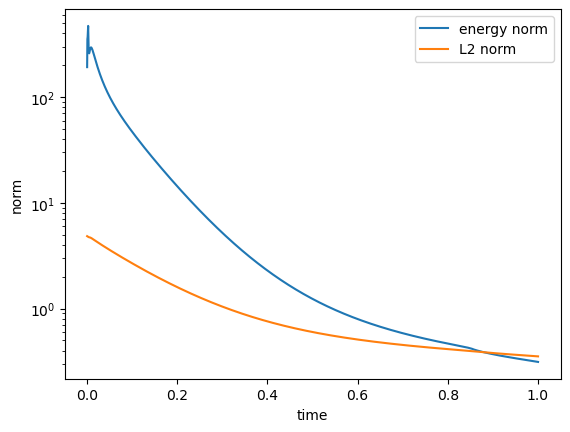

In [22]:
random_heat = DLR(dt = 0.0017/3,n = 7,M = 10)
random_heat.explicit_simulate(end = 1)



energy norm:  188.5222986789227
L2 norm:  4.845082949257364
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
  Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
energy norm:  326.0915668521457
L2 norm:  4.829448432517168
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  308.2544946234026
L2 norm:  4.825967390259665
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  303.6092450332487
L2 norm:  4.824330923248449
Solving linear variational problem.
Solving linear varia

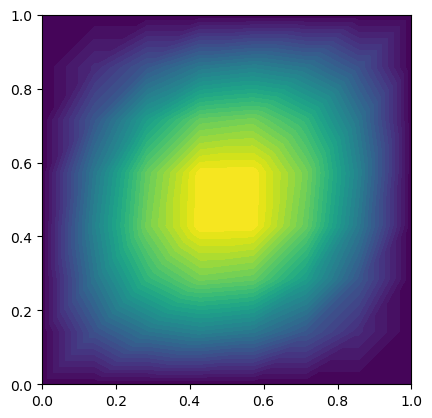

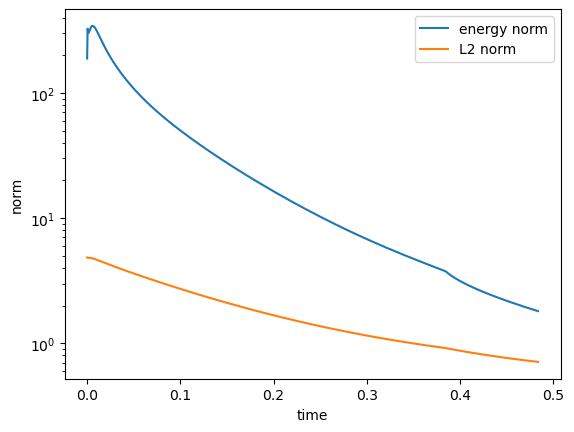

In [16]:
random_heat = DLR(dt = 0.0005,n = 7,M = 10)
random_heat.explicit_simulate(end = 1)

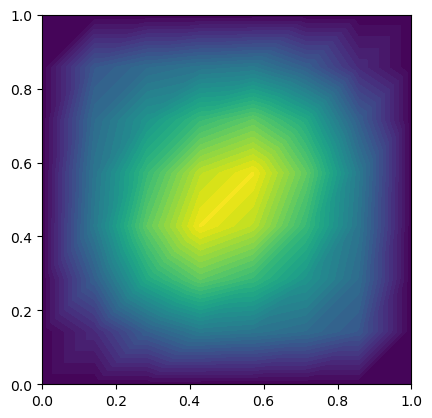

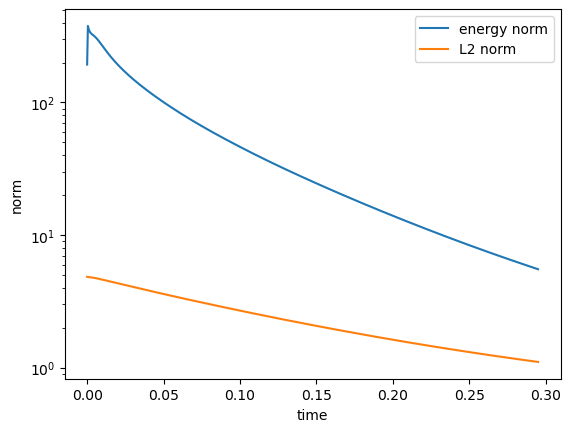

In [14]:
random_heat.plot_field()
random_heat.plot_norm()

energy norm:  184.9872120795749
L2 norm:  4.845082949257364
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.Calling FFC just-in-time (JIT) compiler, this may take some time.

Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
energy norm:  2.0830642852727808
L2 norm:  0.04647879833417831
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  0.17067687977884582
L2 norm:  0.03145427070217135
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  0.00459220017038075
L2 norm:  0.004509090670846279
Solving linear variational problem.
Solving linear v

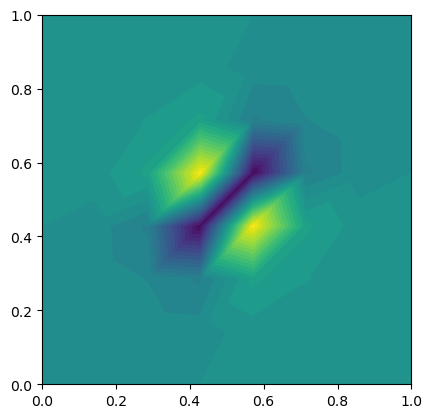

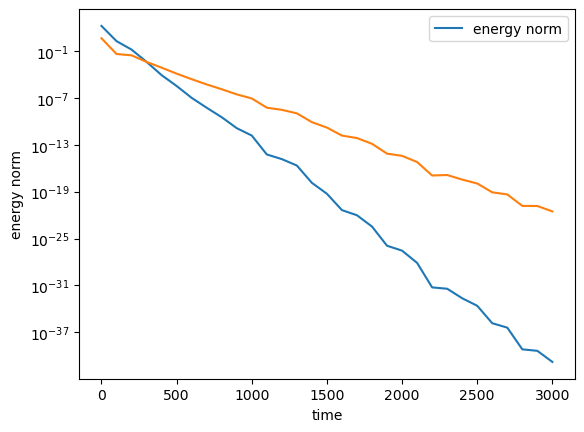

In [6]:
random_heat = DLR(dt = 100,n = 7,M = 10)
random_heat.semi_implicit_simulate(end=3000)

energy norm:  185.73307330847507
L2 norm:  4.845082949257364
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
energy norm:  2181.820069430263
L2 norm:  4.791048772152279
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  3161.3864531018776
L2 norm:  5.661489458603591
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  4304.2601822609795
L2 norm:  6.115346307109703
Solving linear variational problem.
Solving linear variationa

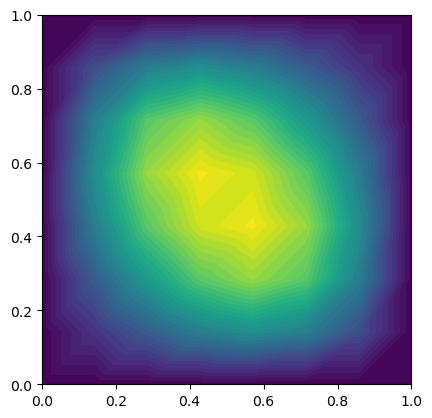

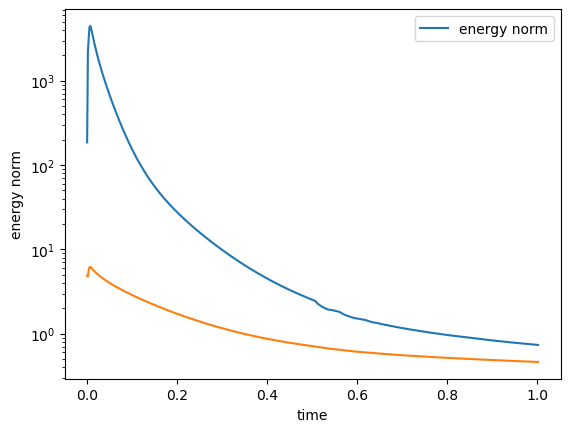

In [14]:
random_heat = DLR(dt = 0.0017,n = 7,M = 10,sample_size = 100)
random_heat.explicit_simulate(end = 1)

In [12]:
random_heat = DLR(dt = 0.01,n = 7,M = 10,sample_size = 100)
random_heat.semi_implicit_simulate(end = 2.5)

energy norm:  188.92659866433394
L2 norm:  4.845082949257364
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Solving linear variational problem.
energy norm:  157.5418936979938
L2 norm:  4.553582484506769
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  142.94519937986098
L2 norm:  4.294898183467147
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  108.60571552457485
L2 norm:  4.03569252152

Exception ignored in: <function Expr.__del__ at 0x10b7016c0>
Traceback (most recent call last):
  File "/Users/naoki/miniconda3/envs/fenicsproject/lib/python3.12/site-packages/ufl/core/expr.py", line 118, in __del__
    def __del__(self):

KeyboardInterrupt: 


energy norm:  2.4286958060255958e-11
L2 norm:  1.97792843817942e-06
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
energy norm:  2.1513204662815754e-11
L2 norm:  1.8608239336700595e-06
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


KeyboardInterrupt: 

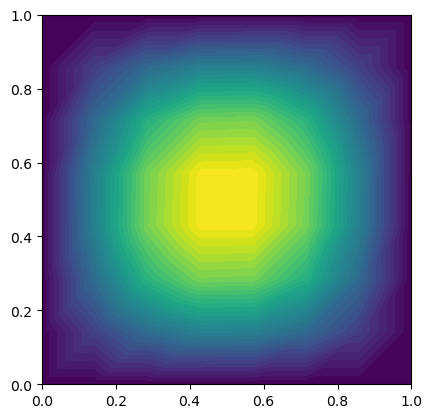

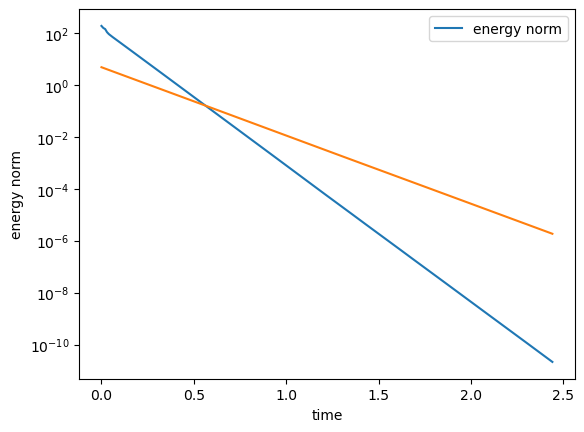

In [13]:
random_heat.plot_field()
random_heat.plot_norm()